In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [5]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array([0, 1], dtype=int64)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=1)

### Pipeline

In [16]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))

In [27]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Acurácia no teste: {:.2f} %'.format(pipe_lr.score(X_test, y_test) * 100))

Acurácia no teste: 95.61 %


### Kfold

In [34]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

In [35]:
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    
    print('Fold:%2d, Acurácia: %.3f' % (k + 1, score))

Fold: 1, Acurácia: 0.935
Fold: 2, Acurácia: 0.935
Fold: 3, Acurácia: 0.957
Fold: 4, Acurácia: 0.957
Fold: 5, Acurácia: 0.935
Fold: 6, Acurácia: 0.956
Fold: 7, Acurácia: 0.978
Fold: 8, Acurácia: 0.933
Fold: 9, Acurácia: 0.956
Fold:10, Acurácia: 0.956


In [38]:
print('Acurácia CV: %.3f' % np.mean(scores))

Acurácia CV: 0.950


### Cross val score

In [41]:
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                         cv=10,
                        n_jobs=4)
print('Acurácias CV: %s' % scores)

Acurácia CV: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [42]:
print('Acurária CV: %.3f' % (np.mean(scores)))

Acurária CV: 0.950


### Curvas de aprendizado

In [45]:
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         solver='lbfgs',
                                         max_iter=1000))

In [46]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0,10),
                                                       cv=10,
                                                       n_jobs=4)

In [50]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.mean(test_scores, axis=1)

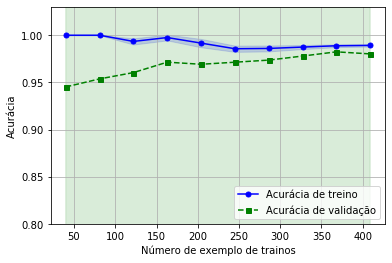

In [51]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Acurácia de treino')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Acurácia de validação')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Número de exemplo de trainos')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

### Curvas de validação

In [53]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='logisticregression__C',
                                            param_range=param_range,
                                            cv=10)

In [54]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.mean(test_scores, axis=1)

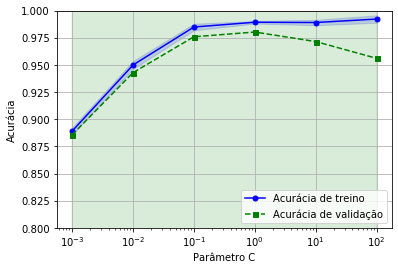

In [55]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Acurácia de treino')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Acurácia de validação')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parâmetro C')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### Grid search

In [61]:
pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
              'svc__kernel': ['linear']},
             {'svc__C': param_range,
             'svc__gamma': param_range,
             'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 refit=True,
                 n_jobs=-1)

In [64]:
gs = gs.fit(X_train, y_train)
print('Score:', gs.best_score_)
print('Melhores parâmetros: ', gs.best_params_)

Score: 0.9846859903381642
Melhores parâmetros:  {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [65]:
# Teste com os melhores hiperparâmetros
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Acurácia no teste: %.3f' % clf.score(X_test, y_test))

Acurácia no teste: 0.974
